In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights

In [2]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform = None):
        super().__init__()
        self.images_dir = image_dir
        self.annotations_dir = annotation_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.images_dir)
    
    def __getitem__(self, index):
        image = Image.open(self.images_dir[index]).convert('RGB')
        bbox, label = self.parse_annotation(self.annotations_dir[index])
        
        if self.transform != None:
            image = self.transform(image)

        return image, label, bbox

    
    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        image_width = int(root.find('size/width').text)
        image_height = int(root.find('size/height').text)

        # Khởi tạo label
        label = None
        bbox = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            if label is None:
                label = name

            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)

            # Normalize bbox coordinates to [0, 1]
            bbox = [
                xmin / image_width,
                ymin / image_height,
                xmax / image_width,
                ymax / image_height,
            ]

        bbox_tensor = torch.tensor(bbox, dtype=torch.float32)
        # Convert label to numerical representation (0 for cat, 1 for dog)
        label_num = 0 if label == "cat" else 1 if label == "dog" else -1
        return bbox_tensor, label_num

In [3]:
def get_count_filename_obj(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    count = 0

    for obj in root.findall('object'):
        count += 1
    return count


def filter_images_with_multiple_obj(images_path, annotations_paths):
        valid_img_paths = []
        valid_img_annotation_paths = []
        for index, annotation_path in enumerate(annotations_paths):
            count = get_count_filename_obj(annotation_path)
            if count <= 1:
                valid_img_paths.append(images_path[index])
                valid_img_annotation_paths.append(annotations_paths[index])
            else:
                print(
                    f"Image {images_path[index]} has multiple objects and will be excluded from the dataset")

        print(f"Total has {len(valid_img_paths)} valid image")

        return valid_img_paths, valid_img_annotation_paths

In [4]:
# Data directory
annotations_dir = '/kaggle/input/dog-and-cat-detection/annotations'
image_dir = '/kaggle/input/dog-and-cat-detection/images'

image_files = [os.path.join(image_dir, f) for f in os.listdir(
    image_dir) if os.path.isfile(os.path.join(image_dir, f))]
annotations_files = [os.path.join(annotations_dir, f) for f in os.listdir(
    annotations_dir) if os.path.isfile(os.path.join(annotations_dir, f))]

# filter image > 1 obj

image_files, annotations_files = filter_images_with_multiple_obj(image_files, annotations_files)

x_train, x_val, y_train, y_val = train_test_split(
    image_files, annotations_files, test_size=0.2, random_state=42)

# Output the result
print("Training set size:", len(x_train))
print("Validation set size:", len(x_val))

y_train[0]

Image /kaggle/input/dog-and-cat-detection/images/Cats_Test1747.png has multiple objects and will be excluded from the dataset
Total has 3685 valid image
Training set size: 2948
Validation set size: 737


'/kaggle/input/dog-and-cat-detection/annotations/Cats_Test1919.xml'

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = ImageDataset(x_train, y_train, transform=transform)
val_dataset = ImageDataset(x_val, y_val, transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Labels: tensor([1, 1, 0, 1, 1, 1, 1, 1])


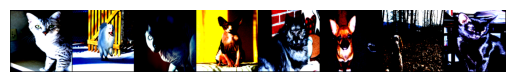

In [6]:
import matplotlib.pyplot as plt
import torchvision

# Hàm để hiển thị hình ảnh
def imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')  # Ẩn trục tọa độ
    plt.show()


# Lấy một batch từ train_loader và hiển thị ảnh
for i, (input_img, labels, bbox) in enumerate(train_loader, 0):
    print(f"Labels: {labels[:8]}")  # In nhãn của 8 ảnh đầu tiên
    # Hiển thị 8 ảnh đầu tiên
    imshow(torchvision.utils.make_grid(input_img[:8]))
    break  # Thoát khỏi vòng lặp sau batch đầu tiên

### Xây dựng model

In [7]:
class TwoHeadedModel(nn.Module):
    def __init__(self, num_classes = 2):
        super().__init__()
        self.base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(
            *list(self.base_model.children())[:-1])
        self.num_classes = num_classes
        self.num_ftrs = self.base_model.fc.in_features

        self.classifier = nn.Linear(self.num_ftrs, num_classes)
        # Bounding box regression head
        self.regressor = nn.Linear(self.num_ftrs, 4)

        
    def forward(self, x):
        x = self.feature_extractor(x)
        # flatten từ trục 1 trở về sau
        x = torch.flatten(x, 1)
        class_logits = self.classifier(x)
        bbox_coords = torch.sigmoid(self.regressor(x))

        return class_logits, bbox_coords

In [8]:
# Model
model = TwoHeadedModel(2)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion_classifier = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Show model summary
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


TwoHeadedModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [9]:
import matplotlib.pyplot as plt

def evaluate(model, val_loader, criterion_classifier, criterion_bbox, device):
    model.eval()
    losses_eval = []
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (image, label, bbox) in enumerate(val_loader):
            image = image.to(device)
            label = label.to(device)
            bbox = bbox.to(device)

            class_logits, bbox_coords = model(image)
            loss_classifier = criterion_classifier(class_logits, label)
            loss_bbox = criterion_bbox(bbox_coords, bbox)
            loss = loss_classifier + loss_bbox

            losses_eval.append(loss.item())

            _, predictions = class_logits.max(1)
            correct += (predictions == label).sum().item()
            total += label.size(0)

    accuracy = float(correct) / float(total) * 100
    avg_loss_eval = sum(losses_eval) / len(losses_eval)

    return avg_loss_eval, accuracy


best_accuracy = 0.0
best_model = None
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    losses_train = []
    model.train()
    for batch_idx, (image, label, bbox) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        bbox = bbox.to(device)

        class_logits, bbox_coords = model(image)
        loss_classifier = criterion_classifier(class_logits, label)
        loss_bbox = criterion_bbox(bbox_coords, bbox)
        loss = loss_classifier + loss_bbox

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_train.append(loss.item())

    avg_loss_train = sum(losses_train) / len(losses_train)
    avg_loss_eval, accuracy = evaluate(
        model, val_loader, criterion_classifier, criterion_bbox, device)

    train_losses.append(avg_loss_train)
    val_losses.append(avg_loss_eval)
    val_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {avg_loss_train:.4f}, "
          f"Validation Loss: {avg_loss_eval:.4f}, "
          f"Validation Accuracy: {accuracy:.2f}%")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model.state_dict()
        torch.save(best_model, '/kaggle/working/best_model_ex2.pth')
        print(f"New best model saved with accuracy: {best_accuracy:.2f}%")



Epoch 1/50, Train Loss: 0.7638, Validation Loss: 0.6805, Validation Accuracy: 66.76%
New best model saved with accuracy: 66.76%
Epoch 2/50, Train Loss: 0.6675, Validation Loss: 0.6775, Validation Accuracy: 67.98%
New best model saved with accuracy: 67.98%
Epoch 3/50, Train Loss: 0.6572, Validation Loss: 0.7672, Validation Accuracy: 68.25%
New best model saved with accuracy: 68.25%
Epoch 4/50, Train Loss: 0.6789, Validation Loss: 0.6818, Validation Accuracy: 63.64%
Epoch 5/50, Train Loss: 0.6620, Validation Loss: 0.6689, Validation Accuracy: 68.25%
Epoch 6/50, Train Loss: 0.6608, Validation Loss: 0.6701, Validation Accuracy: 68.25%
Epoch 7/50, Train Loss: 0.6554, Validation Loss: 0.7594, Validation Accuracy: 63.36%
Epoch 8/50, Train Loss: 0.6501, Validation Loss: 0.7322, Validation Accuracy: 68.25%
Epoch 9/50, Train Loss: 0.6375, Validation Loss: 0.7173, Validation Accuracy: 66.49%
Epoch 10/50, Train Loss: 0.6405, Validation Loss: 0.7334, Validation Accuracy: 68.11%
Epoch 11/50, Train L

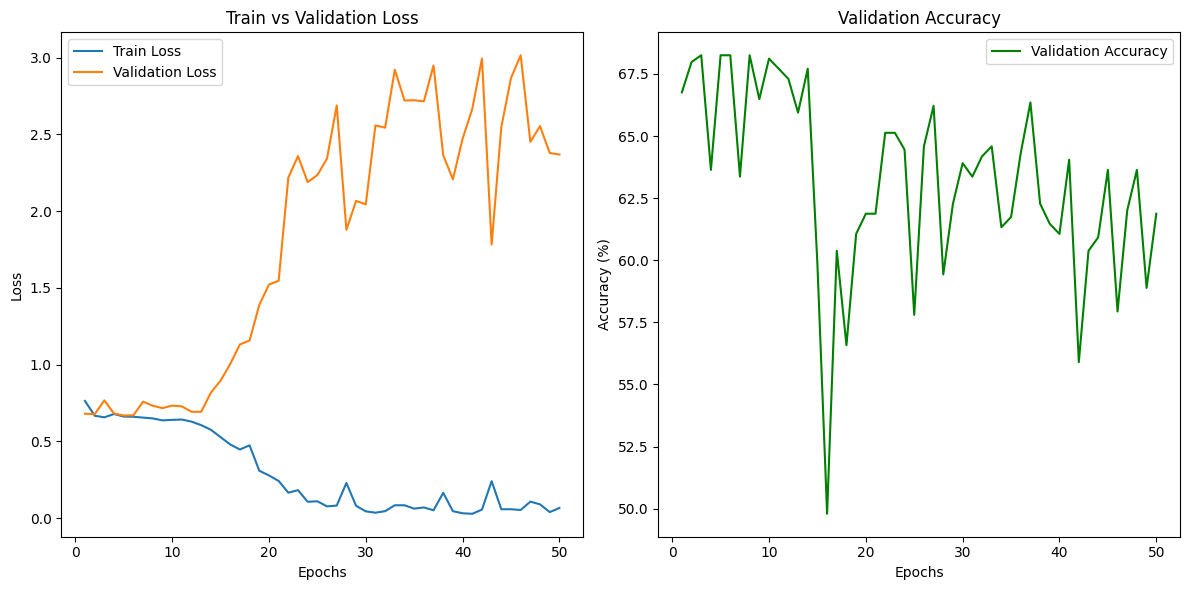

In [10]:
# Visualization
plt.figure(figsize=(12, 6))

# Loss Visualization
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Accuracy Visualization
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies,
         label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    # Lấy kích thước ảnh
    image_width = int(root.find('size/width').text)
    image_height = int(root.find('size/height').text)

    # Khởi tạo label và bounding box
    label = None
    bbox = []

    # Duyệt qua từng object trong annotation
    for obj in root.findall('object'):
        name = obj.find('name').text
        if label is None:
            label = name

        # Lấy tọa độ bounding box
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        # Chuẩn hóa tọa độ bounding box về [0, 1]
        bbox = [
            xmin / image_width,
            ymin / image_height,
            xmax / image_width,
            ymax / image_height,
        ]

    # Chuyển bounding box thành tensor
    bbox_tensor = torch.tensor(bbox, dtype=torch.float32)

    # Chuyển đổi nhãn thành số (0 cho cat, 1 cho dog, -1 cho nhãn không hợp lệ)
    label_num = 0 if label == "cat" else 1 if label == "dog" else -1

    return bbox_tensor, label_num


In [12]:
import cv2
def draw_bounding_boxes(image, predict_bbox, ground_truth_bbox, label, prediction):
    img = image.cpu().permute(1, 2, 0).numpy()

    img = (img * 255).clip(0, 255).astype(np.uint8)

    # OpenCV yêu cầu ảnh phải là BGR, chuyển đổi từ RGB sang BGR
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Vẽ bounding box dự đoán
    pred_xmin, pred_ymin, pred_xmax, pred_ymax = (
        int(predict_bbox[0] * img.shape[1]),
        int(predict_bbox[1] * img.shape[0]),
        int(predict_bbox[2] * img.shape[1]),
        int(predict_bbox[3] * img.shape[0]),
    )
    img = cv2.rectangle(img, (pred_xmin, pred_ymin), (pred_xmax, pred_ymax), (0, 255, 0), 2)
    img = cv2.putText(
        img,
        f"Pred: {prediction}",
        (pred_xmin, max(pred_ymin - 10, 0)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 0),
        1,
        cv2.LINE_AA,
    )

    # Vẽ bounding box ground truth
    gt_xmin, gt_ymin, gt_xmax, gt_ymax = (
        int(ground_truth_bbox[0] * img.shape[1]),
        int(ground_truth_bbox[1] * img.shape[0]),
        int(ground_truth_bbox[2] * img.shape[1]),
        int(ground_truth_bbox[3] * img.shape[0]),
    )
    img = cv2.rectangle(img, (gt_xmin, gt_ymin), (gt_xmax, gt_ymax), (255, 0, 0), 2)
    img = cv2.putText(
        img,
        f"GT: {label}",
        (gt_xmin, max(gt_ymin - 10, 0)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 0, 0),
        1,
        cv2.LINE_AA,
    )

    # Chuyển từ BGR sang RGB để hiển thị bằng Matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Hiển thị ảnh trong Matplotlib
    plt.imshow(img)
    plt.title("Bounding Box Prediction and Ground Truth")
    plt.axis("off")
    plt.show()


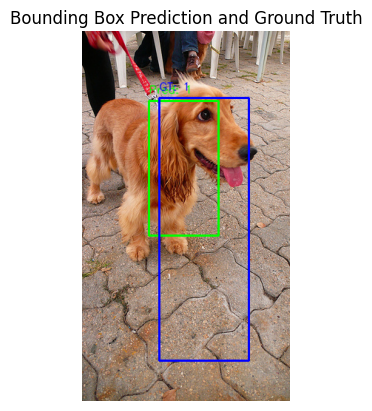

Test Loss: 0.7127, Test Accuracy: 100.00%


In [13]:
def test(model, x_val, y_val, criterion_classifier, criterion_bbox, device):
    model.eval()
    losses_eval = []
    correct = 0
    total = 0

    with torch.no_grad():
        for image_path, label_path in zip(x_val, y_val):
            # Mở ảnh và chuyển đổi sang tensor
            image = Image.open(image_path).convert('RGB')
            image = transforms.ToTensor()(image).to(device)  # Không cần unsqueeze(0)

            # Lấy annotation
            bbox, label = parse_annotation(label_path)
            bbox = bbox.to(device)
            label = torch.tensor(label, dtype=torch.long).to(device)  # Không cần thêm chiều batch

            # Tính toán dự đoán
            class_logits, bbox_coords = model(image.unsqueeze(0))  # Thêm chiều batch tại đây
            loss_classifier = criterion_classifier(class_logits, label.unsqueeze(0))
            loss_bbox = criterion_bbox(bbox_coords, bbox.unsqueeze(0))
            loss = loss_classifier + loss_bbox

            losses_eval.append(loss.item())

            _, predictions = class_logits.max(1)
            correct += (predictions.item() == label.item())
            total += 1

            # Hiển thị bounding box
            draw_bounding_boxes(
                image.cpu(),                # Ảnh gốc
                bbox_coords[0].cpu().numpy(), # Bounding box dự đoán
                bbox.cpu().numpy(),          # Bounding box ground truth
                label.item(),                # Nhãn thực tế
                predictions.item(),          # Nhãn dự đoán
            )

            break  # Dừng sau sample đầu tiên để kiểm tra

    # Tính kết quả
    accuracy = (correct / total) * 100 if total > 0 else 0
    avg_loss_eval = sum(losses_eval) / len(losses_eval) if len(losses_eval) > 0 else 0

    return avg_loss_eval, accuracy


    
avg_loss, acc = test(model, x_val, y_val, criterion_classifier, criterion_bbox, device)
print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {acc:.2f}%")
